# Short Term Forecasting of Solar Energy Production

Analysis by Matt Carr

## Overview
Over the past decade, renewable energy sources have seen massive growth due to decreasing costs and environmental benefits. However, due to the intermittent nature of these resources, integratation into the current electric grid has proved challenging. At any given time, the electricity consumption from the grid must be balanced with the electricity generation going into the grid. If this balance is not kept, it can lead to grid failures that can produce power outages and even black outs. To improve grid management and reliability, grid operators need an idea of how much energy will be put into the grid from fluctuating, renewable sources so they are able to make up the remaining energy needed to match demand with other sources.

The goal of this project is to create a model that can predict how much energy a solar farm will produce three hours in advance. This is the first stage of the project. In future stages I hope to create a model that can predict solar energy production one to six hours in advance. This will allow grid operators the chance to integrate conventional sources into the grid at the right time and improve grid efficiency as well as reduce the emissions caused by conventional sources. 

This analysis focuses on the affect weather conditions have on solar energy production, and attempts to use these features to predict energy output three hours in the future.

### Data Used:
- Solar energy data was scraped from University of Illinois Solar Farm dashboard
- Weather data downloaded from NOAA. Nearest weather station to Solar Farm
- Dates range from January 30, 2018 to July 20, 2020
- Data Definitions:
    - nexus_meter -> Energy produced from solar farm in kilowatt hours
    - week -> Week of year energy was produced
    - hour -> Hour of day energy was produced
    - HourlyAltimeterSetting -> atmospheric pressure reduced to sea level. Given in Hg (inches of Mercury)
    - HourlyDewPointTemperature -> dew point temperature in F
    - HourlyDryBulbTemperature -> Temperature in F
    - HourlyRelativeHumidity -> Humidity given in nearest whole percentage
    - HourlyStationPressure -> atmospheric pressure at station in Hg (inches of Mercury)
    - HourlyVisibility -> Horizontal distance an object can be seen given in whole miles
    - HourlyWindSpeed -> speed of wind in mph
    - HourlyWindDirection -> Wind direction from true north using compass directions
    - HourlyPrecipitation -> Amount of precipitation in inches
    - cloud_coverage -> percent cloud coverage

For more information on weather variables, refer to LCD_documentation.pdf in references/ directory.

## Notebook Contents
- Imports
- Data Exploration
- Data Processing
- Baseline Model
- Second Iteration
- Final Model Iteration
- Conclusions

### NOTE
Before attempting to run the code in this notebook, make sure you have installed and activated the Anaconda environment. Instructions on how to do this can be found in the README.




## Imports

I will begin by importing the libraries that will be used throughout this analysis. This notebook utilizes functions found in the .py files from the src/ directory. The libraries used will allow for dataframe manipulation, visualizations, data processing, and effective modeling.

In [2]:
# Import Libraries

# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Preprocessing
from sklearn.preprocessing import StandardScaler

# Modeling Metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer

# Cross Validation
from sklearn.model_selection import train_test_split, cross_val_score

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Use functions from .py file
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import src.data_gathering as dg
import src.web_scraper as ws
import src.data_processing as dp

#### Data imports

This project utilizes data from multiple sources (more information on specific sources in README). Both the energy output and weather data span the time period from January 29, 2018 to July 20, 2020. The energy data is scraped in fifteen minute increments and aggregated to hourly time index before modeling. The weather data has less consistent time increments, but is also aggregated to hourly time index before modeling.

All of the specific data used for this project is contained within this repo. However, if you wish to update the data to include more recent dates, you can do so. Instructions on where to download the weather data can be found in the README. The webscraper used the download to energy data from the University of Illinois Solar Farm dashboard is accessible below. Simply uncomment the cell below and indicate the start date and end date you would like to analyze. If you just want to add dates to the analysis start from July 20, 2020 until the date of your choosing. If you would like to analyze different dates entirely, be sure to delete the current energy files from the data/solar_output/ directory before hand. Also indicate the directory you would like to store the files in, the files are stored in current working directory by default.

Make sure you collect energy data and weather data from the same dates.

In [3]:
# # Uncomment and run this cell to download energy data

# # Indicate start date, end date, and directory for files to be stored in.
# start_date = None
# end_date = None
# directory = None

# # Instantiate scraper object
# scraper = ws.EnergyScraper(directory=directory)

# # Download files
# scraper.download_files(start_date, end_datet)

# # close driver
# scraper.close()

I utilize the functions from data_gathering.py file in the src/ directory to do the initial formatting of the energy and weather dataframes. More specific information on data processing can be found in the README. All energy files are read in and stored in a single dataframe and aggregated into an hourly time index. The weather file is stored in a dataframe and the columns used throughout this analysis are chosen. There were a few cleaning steps involved with the weather dataframe such as a few symbols that needed to be converted to NaN as well as multiple values that contained an extraneous letter on the end. All of this is taken care of with the functions in the .py file. Below I will import both the base energy dataframe and base weather dataframe.

In [4]:
# energy dataframe
energy = dg.energy_data()
weather = dg.weather_data()

In [5]:
energy.head()

,nexus_meter,week,hour
time,,,
2018-01-30 00:00:00,0.0,5,0
2018-01-30 01:00:00,0.0,5,1
2018-01-30 02:00:00,0.0,5,2
2018-01-30 03:00:00,0.0,5,3
2018-01-30 04:00:00,0.0,5,4


In [6]:
weather.head()

,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWindSpeed,HourlyWindDirection,HourlyPrecipitation,cloud_coverage
DATE,,,,,,,,,,
2018-01-29 00:23:00,30.34,28,30,92,29.51,5.00,14,330,NaN,80.0
2018-01-29 00:42:00,30.35,28,30,92,29.52,6.00,13,320,NaN,80.0
2018-01-29 00:51:00,30.34,28,30,93,29.51,6.00,15,330,NaN,80.0
2018-01-29 00:53:00,30.34,28,30,92,29.51,6.00,15,330,0.00,80.0
2018-01-29 01:53:00,30.34,28,30,92,29.51,3.00,10,340,0.00,80.0


Both dataframes are imported and formatted properly. The energy dataframe contains two additional columns other than energy production (nexus_meter). Week indicates the week of the year and hour indicates the hour of the day. Both the time of year and the time of day are important indicators of how much energy is likely to be produced and are therefore useful features for the model. I used the time index from the energy dataframe rather than the weather dataframe for that exact reason. I want to know the time of day and time of year at the time energy is being produced, not at the time a prediction is being made.

There are also a few missing values in the weather dataframe. I will use the function impute_df from the data_processing.py file in the src/ directory to impute these missing values. This function utilizes IterativeImputer, which a multivariate imputation method. Essentially it runs a regression on each row that is missing data, and uses the non-missing values to impute the missing values. I am going to store the imputed weather dataframe in the variable weather_df.

In [7]:
weather_df = dp.impute_df(weather)

Now that the missing weather data has been imputed, I can aggregate the weather datafrmae into an hourly time index. I take the average of each observation within a given hour to compute the hourly values.

In [8]:
weather_hourly = weather_df.resample('H').mean()

In [9]:
weather_hourly.head()

,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWindSpeed,HourlyWindDirection,HourlyPrecipitation,cloud_coverage
DATE,,,,,,,,,,
2018-01-29 00:00:00,30.3425,28.0,30.0,92.25,29.5125,5.75,14.25,327.5,0.017317,80.0
2018-01-29 01:00:00,30.3400,28.0,30.0,92.00,29.5100,3.00,10.00,340.0,0.000000,80.0
2018-01-29 02:00:00,30.3300,28.0,30.0,92.00,29.5000,5.00,13.00,340.0,0.000000,80.0
2018-01-29 03:00:00,30.3300,28.0,30.0,92.00,29.5000,6.00,13.00,320.0,0.000000,80.0
2018-01-29 04:00:00,30.3300,28.0,30.0,92.50,29.5000,6.00,10.50,325.0,0.009066,80.0


The weather data is now stored in hourly format. The next step is to combine the energy data with the weather data so I can begin exploring and modeling. I will utilize the function create_base_df from the data_processing.py file to do this. In order to use current weather conditions to predict energy output three hours in the future, I need to structure the dataframe a certain way. Specifically, I need to incorporate a three hour (or three row) lag between the weather conditions and the energy data. This means that for any given row, the energy data is paired with the weather conditions three hours prior. For example, the energy production on July 1, 2020 at 11am will be paired with the weather conditions on July 1, 2020 at 8am. The function does this for me.

In [10]:
base_df = dp.create_base_df(energy, weather_hourly)

In [11]:
base_df.head()

,nexus_meter,week,hour,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWindSpeed,HourlyWindDirection,HourlyPrecipitation,cloud_coverage
DATE,,,,,,,,,,,,,
2018-01-30 00:00:00,0.0,5.0,0.0,30.47,15.0,19.0,84.0,29.64,10.0,6.0,310.0,0.0,0.0
2018-01-30 01:00:00,0.0,5.0,1.0,30.48,13.0,17.0,84.0,29.65,10.0,6.0,320.0,0.0,0.0
2018-01-30 02:00:00,0.0,5.0,2.0,30.48,13.0,17.0,84.0,29.65,10.0,5.0,300.0,0.0,0.0
2018-01-30 03:00:00,0.0,5.0,3.0,30.46,14.0,17.0,88.0,29.63,10.0,6.0,310.0,0.0,0.0
2018-01-30 04:00:00,0.0,5.0,4.0,30.47,11.0,15.0,84.0,29.64,10.0,6.0,320.0,0.0,0.0


We can ensure this dataframe is formatted correctly by investigating the energy and weather dataframes individually.

In [12]:
energy.head(15)

,nexus_meter,week,hour
time,,,
2018-01-30 00:00:00,0.0,5,0
2018-01-30 01:00:00,0.0,5,1
2018-01-30 02:00:00,0.0,5,2
2018-01-30 03:00:00,0.0,5,3
2018-01-30 04:00:00,0.0,5,4
2018-01-30 05:00:00,0.0,5,5
2018-01-30 06:00:00,0.0,5,6
2018-01-30 07:00:00,0.0,5,7
2018-01-30 08:00:00,0.0,5,8


At 11am on July 30, 2018, there were 10,128 kWh of energy produced. The weather conditions at this time index in the base_df, should match up with the weather conditions at 8am on July 30, 2018 in the weather_hourly dataframe.

In [13]:
weather_hourly.loc['2018-01-30 08:00:00']

HourlyAltimeterSetting        30.530000
HourlyDewPointTemperature     13.000000
HourlyDryBulbTemperature      21.000000
HourlyRelativeHumidity        71.000000
HourlyStationPressure         29.700000
HourlyVisibility              10.000000
HourlyWindSpeed                3.000000
HourlyWindDirection          166.892929
HourlyPrecipitation            0.000000
cloud_coverage                 0.000000
Name: 2018-01-30 08:00:00, dtype: float64

In [14]:
base_df.loc['2018-01-30 11:00:00']

nexus_meter                  10128.000000
week                             5.000000
hour                            11.000000
HourlyAltimeterSetting          30.530000
HourlyDewPointTemperature       13.000000
HourlyDryBulbTemperature        21.000000
HourlyRelativeHumidity          71.000000
HourlyStationPressure           29.700000
HourlyVisibility                10.000000
HourlyWindSpeed                  3.000000
HourlyWindDirection            166.892929
HourlyPrecipitation              0.000000
cloud_coverage                   0.000000
Name: 2018-01-30 11:00:00, dtype: float64

Based on the values above, I can verfiy that the base dataframe is formatted correctly. Next I can proceed to exploring the data.

## Data Exploration

I will begin by looking at how energy production fluctuates with time. To do this I will plot the energy production over the entire time period being analyzed. I want to focus on how energy production fluctuates throughout the year, so I will also plot the thirty day rolling average of energy output to visualize the overall trend. First I will need to resample the energy data into a daily time index, then I will be able to take calculate the thirty day rolling mean.

In [15]:
daily_energy = base_df['nexus_meter'].resample('D').sum()

In [16]:
# calculate 30 day
energy_monthly_mean = daily_energy.rolling(30).mean()

Plot total daily energy production along with 30 day rolling mean

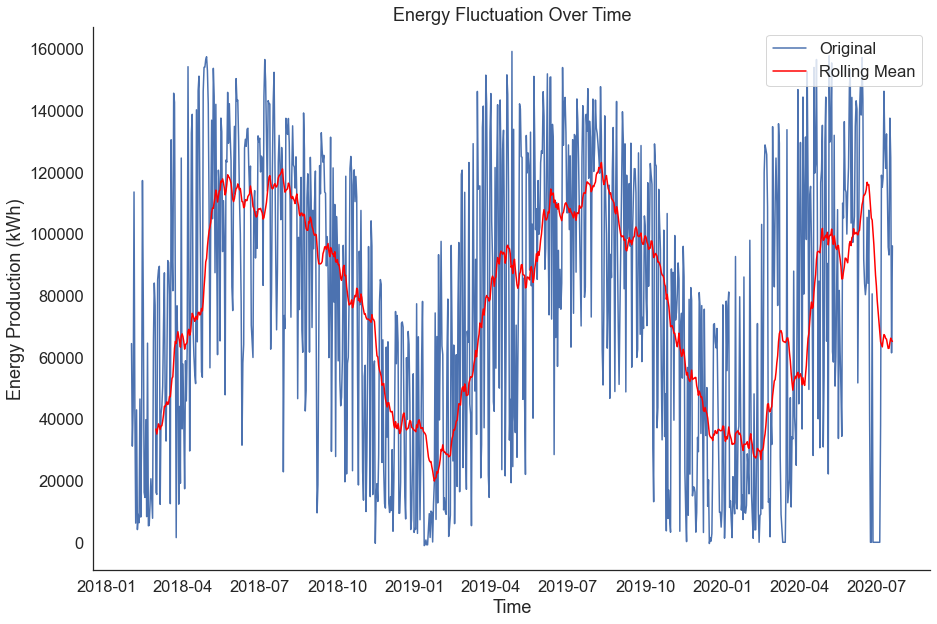

In [17]:
# create figure
sns.set(font_scale=1.5)
sns.set_style('white')
sns.set_context({'figure.figsize': (15, 10)})

# plot lines
splot = sns.lineplot(data=daily_energy, label='Original')
sns.lineplot(data=energy_monthly_mean, color='red', label='Rolling Mean')

# add title and labels
splot.set_title('Energy Fluctuation Over Time')
splot.set_xlabel('Time')
splot.set_ylabel('Energy Production (kWh)')

# create legend and despine plot
splot.legend(loc='best')
sns.despine()

This plot provides some important information. First, looking at the red line which denotes the thirty day rolling mean and highlights the overall trend of energy production throughout the year, we can see that energy production is much higher in warmer months than cooler months. The plot reaches its relative minimum in the Winter and begins rising in early Spring, reaching its relative peak around the middle of the Summer. This is why including the week of the year we are predicting for is so important for the model's results, because the time of year has a strong affect on how much energy is being produced.

The other thing we can see from the plot above is the immense amount of noise in the original daily plot (blue line). This is due to the influence that weather conditions have on solar energy production, and the natural fluctuations of weather conditions. Although the time of year is a strong indication of how much energy may be produced, weather conditions cannot be overlooked. Looking at a few of the days in January 2019, we can see that they actually produced more eergy than a few days in June of that same year. This is because weather has such a strong influence on energy production; a sunny day in January will produce more energy than a cloudy day in June. 

In order to produce the best predictions, both time and weather must be taken into account.

Another thing to note is that in order for a solar panel to produce energy, the solar irradiance from the sun must get through to the panel itself. Meaning the sun must be shining. The solar farm being analyzed above is located in the midwest, which has much shorter days in the Winter than in Spring or Summer. Less overall sunlight means less energy produced.

Next I would like to show how dependent energy production is on the weather. To do this, I will create a barplot showing the correlation between a few of the weather conditions and the energy production. For this visual, I will now include the lag between weather conditions and energy production. The reason being I want to show how energy production is dependent upon the weather at the time of output, not from three hours prior. The lag is incorporated for modeling purposes only.

In [18]:
pd.concat([energy, weather_hourly], axis=1).corr()['nexus_meter']

nexus_meter                  1.000000
week                         0.025981
hour                         0.059122
HourlyAltimeterSetting       0.043414
HourlyDewPointTemperature    0.137557
HourlyDryBulbTemperature     0.394223
HourlyRelativeHumidity      -0.683691
HourlyStationPressure        0.043220
HourlyVisibility             0.246738
HourlyWindSpeed              0.122963
HourlyWindDirection          0.084774
HourlyPrecipitation         -0.077797
cloud_coverage              -0.190784
Name: nexus_meter, dtype: float64

I only want to include the features that have a significant correlation with energy production. The top five predictors in order of magnitude of correlation are humidity, temperature, visibility, cloud coverage, and dew point temperature. These are the five I am going to include in the visualization.

In [19]:
# Find correlations between energy production and weather conditions and store in variable, corrs
# values will be sorted by absolute value.
corrs = sorted(pd.concat([energy, weather_hourly], axis=1).corr()['nexus_meter'].values, key=abs)


Now that I have the correlation values stored, I can select the top five features from the list. The correlation between nexus_meter and itself is still included, so I will take the last 5 before the final value, which is 1.

In [20]:
# Select top five predictors
top_feats = corrs[-6:-1]
# Store name of predictors in list
feats = ['Dew Point Temp', 'Cloud Cover', 'Visibility', 'Temperature', 'Humidity']

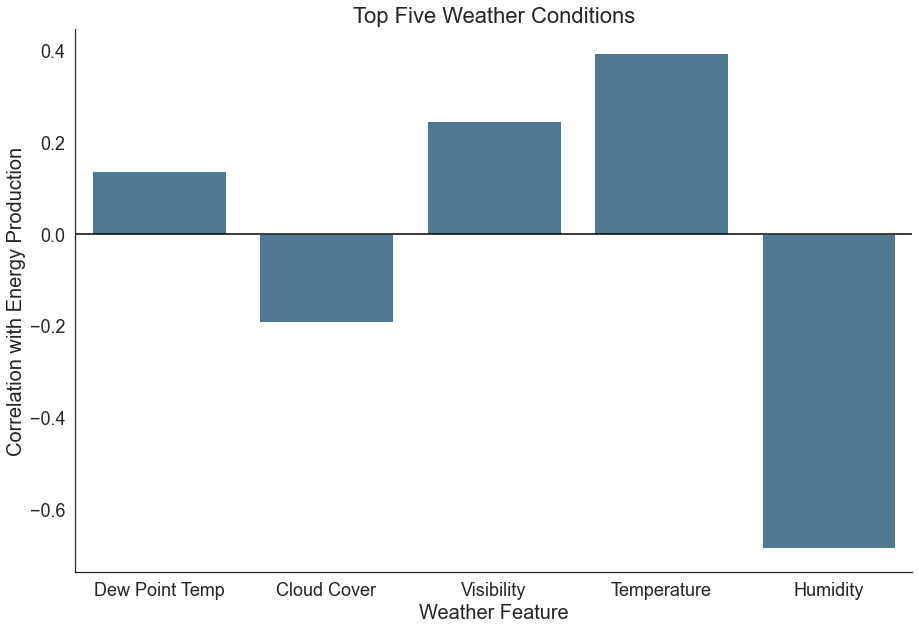

In [21]:
# Create figure
sns.set(font_scale=1.5)
sns.set_style('white')
sns.set_context({'figure.figsize': (15, 10)})

# Barplot with horizontal line at 0
splot = sns.barplot(feats, top_feats, color='#457b9d')
splot.axhline(0, color='black')

# Set title and labels
splot.set_title('Top Five Weather Conditions', fontsize=22)
splot.set_xlabel('Weather Feature', fontsize=20)
splot.set_ylabel('Correlation with Energy Production', fontsize=20)

# Change size of major ticks and despine plot
splot.tick_params(which='major', labelsize= 18)
sns.despine()

As you can see from the plot above, solar energy production has a fairly strong relationship with a few different weather conditions. The three bars above the horizontal black line have a direct relationship with energy production, while the two below have an indirect relationship. These all make sense when you consider how they affect solar irradiance reaching the solar panels. For example, when temperature is higher, it typically means more sunlight is reaching the surface of the Earth, this in turn allows for more solar energy to be produced. As visibility goes up and there is less fog or air particles preventing solar energy from reaching the panels, more energy can be produced. In that same sense, when there is more cloud cover, less solar irradiance is able to reach the solar panels and this decreases the amount of energy they create. Humidity is an interesting one. We can see from the plot that humidity has the strongest affect on how much energy is produced. As humidity increases, small water droplets can form on the solar panels themselves, preventing the solar energy from reaching the panel directly. In addition to that, the moisture in the air can damage the panels, making them less efficient and unable to produce as much solar energy. For more information on how humidity affects the production of solar energy, refer to reference number 5 in the references README.

## Data Processing

The next and last step before modeling is to process the data. I first need to subset the modeling dataframe to only include observations between 5am and 8pm, as these were the times shown to actually produce solar energy. I will create a new dataframe called model_df as a subset of the base_df created earlier. 

### NOTE
Datetime indices such as those used these dataframes are in 24 hour format. 5am is still 5, but 8pm is denoted as 20.

In [22]:
model_df = base_df[(base_df.index.hour >= 5) & (base_df.index.hour <= 20)]

In [23]:
model_df.shape

(14448, 13)

Next I can perform a train test split. The modeling dataframe has 14,448 total observations. A 75/25 train test split will give me 10,836 data points for training and 3,612 for testing. So after I separate the target and features, I will perform a 75%/25% train test split.

In [24]:
# Separate target and features

# Target
y = model_df['nexus_meter']

# features
X = model_df.drop('nexus_meter', axis=1)

Now I can perform the train test split.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)

The baseline model used in this project did not include the week of year or hour of day as features. So I will disclude those when running the baseline model. Below I scale two different sets of training data, one without the time features for the baseline model and one with the time features for future iterations.

In [26]:
# instantiate StandardScaler
scaler_baseline = StandardScaler()
scaler_iterations = StandardScaler()

In [27]:
# Scale training data for baseline model and further iterations
X_baseline_scaled = scaler_baseline.fit_transform(X_train.drop(['week', 'hour'], axis=1))
X_train_scaled = scaler_iterations.fit_transform(X_train)

## Baseline Model

The baseline model used was a LinearRegression model. To get a better understanding of how the model performs on all data, I will score it using cross-validation. The metric I am using is RMSE.

In [28]:
# instantiate LinearRegression
lr = LinearRegression()

In [29]:
# instantiate MSE scorer object
mse_score = make_scorer(mse)

In [30]:
# RMSE score over 5 splits of training data
(np.sqrt(cross_val_score(lr, X_baseline_scaled, y_train, scoring=mse_score, cv=5))).mean()

5030.556961416868

The target value ranges from 0 to about 17,500. The baseline model produced an RMSE of just over 5,000, which means that on average the model's predictions were off by about 5,000. Considering that this is nearly a third of the target value's range, its safe to say this model is not performing that well. Let's attempt to improve this in further model iterations.

## Second Model Iteration

This second iteration will include the week of year and hour of day as features. As pointed out during data exploration, the time of year and time of day both have a strong influence on how much solar energy will be produced. The addition of these features should help the model predict solar energy production. For this second model iteration, I will use a Random Forest Regressor which is a more complex model than Linear Regression and should produce better results.

In [31]:
# Instantiate RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

In [32]:
# RMSE score over 5 splits of training data
(np.sqrt(cross_val_score(rf, X_train_scaled, y_train, scoring=mse_score, cv=5))).mean()

2457.803236160357

This second iteration produced an RMSE score that was less than half of the baseline RMSE score. This second iteration predictions are off by about 2,500 on average. Considering this is still about 15% of the target value's range, these predictions are not great, but much better than the baseline model's performance. In this last model iteration, I will change a few of the RandomForestRegressor hyperparameters to try and improve the prediction performance.

## Final Model Iteration

For this final iteration I want to change the following hyperparameters: max_depth, n_estimators, and min_impurity_decrease. I increase the number of estimators to get a larger number of prediction to average, and hopefully improve overall model predictions. Max_depth and min_impurity_decrease are set to prevent the model from splitting over a small change in one of the weather features, which won't change the solar energy production all that much.

In [33]:
rf2 = RandomForestRegressor(random_state=42, max_depth=25, n_estimators=250, min_impurity_decrease=.25)

In [34]:
# RMSE score over 5 splits of training data
(np.sqrt(cross_val_score(rf2, X_train_scaled, y_train, scoring=mse_score, cv=5))).mean()

2445.712537642036

The final model performed slightly better than the second iteration, but still a lot of room for improvement. Now I can check how this model performs on the testing data to get an idea of how it generalizes to unseen data.

In [35]:
rf2.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=25, min_impurity_decrease=0.25,
                      n_estimators=250, random_state=42)

In [36]:
# scale testing data with scaler_iterations
X_test_scaled = scaler_iterations.transform(X_test)

In [37]:
train_preds = rf2.predict(X_train_scaled)
test_preds = rf2.predict(X_test_scaled)

In [38]:
print('Training RMSE: {}\nTesting RMSE: {}'.format(mse(y_train, train_preds, squared=False), mse(y_test, test_preds, squared=False)))

Training RMSE: 886.7564669178753
Testing RMSE: 2297.0502676781875


This model performed very well on the training set but unfortunately was slightly overfit, which led to a worse performance on the testing set. Ideas on how to address this will be discussed in the next steps section of the README.

## Conclusions

The final model's predictions produced an average error of 2297 on the testing set. This is a rather large error, as grid operators would have to include this possible error margin when operating the grid. To account for this error, it is likely they would have other sources running so they would be able to supply the grid with additional energy on short notice. This is inefficient and increases the very emissions we are trying to avoid. To improve grid operation efficiency, this model's average error must go down which will be worked towards in the next stages of this project.